In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')

#Visulization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Machine Learning
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.linear_model import LogisticRegression

#Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, auc
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

#HyperParameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

## 데이터 준비

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
t_data = pd.read_csv(r'C:\Users\김상휘\Desktop\Hwi\한이음-kt\data\telecom_data.csv', encoding='euc-kr',engine='python')
t_data.rename(columns= t_data.iloc[0],inplace=True)
t_data.drop(t_data.index[0],axis=0,inplace=True)

# 1. 전처리

## 1-1. 결측치 처리

In [4]:
t_data['TotalCharges'] = t_data['TotalCharges'].replace(" ",np.nan)
t_data.dropna(inplace=True)
t_data.drop('customerID',axis=1,inplace=True)

## 1-2. 타입 변경하기

In [5]:
col1 = ['MonthlyCharges','TotalCharges']
for i in col1:
    t_data[i] = t_data[i].astype(float)

t_data['tenure'] = t_data['tenure'].astype(int)
t_data.dtypes

gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int32
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

## 1-3. 이탈 = 1 / 이탈하지 않음 = 0

In [6]:
t_data.loc[t_data.Churn == 'No','Churn'] = 0
t_data.loc[t_data.Churn == 'Yes', 'Churn'] = 1
t_data.Churn = t_data.Churn.astype(int)

# 2. EDA

## 2-1. 특성별 빈도수 파악

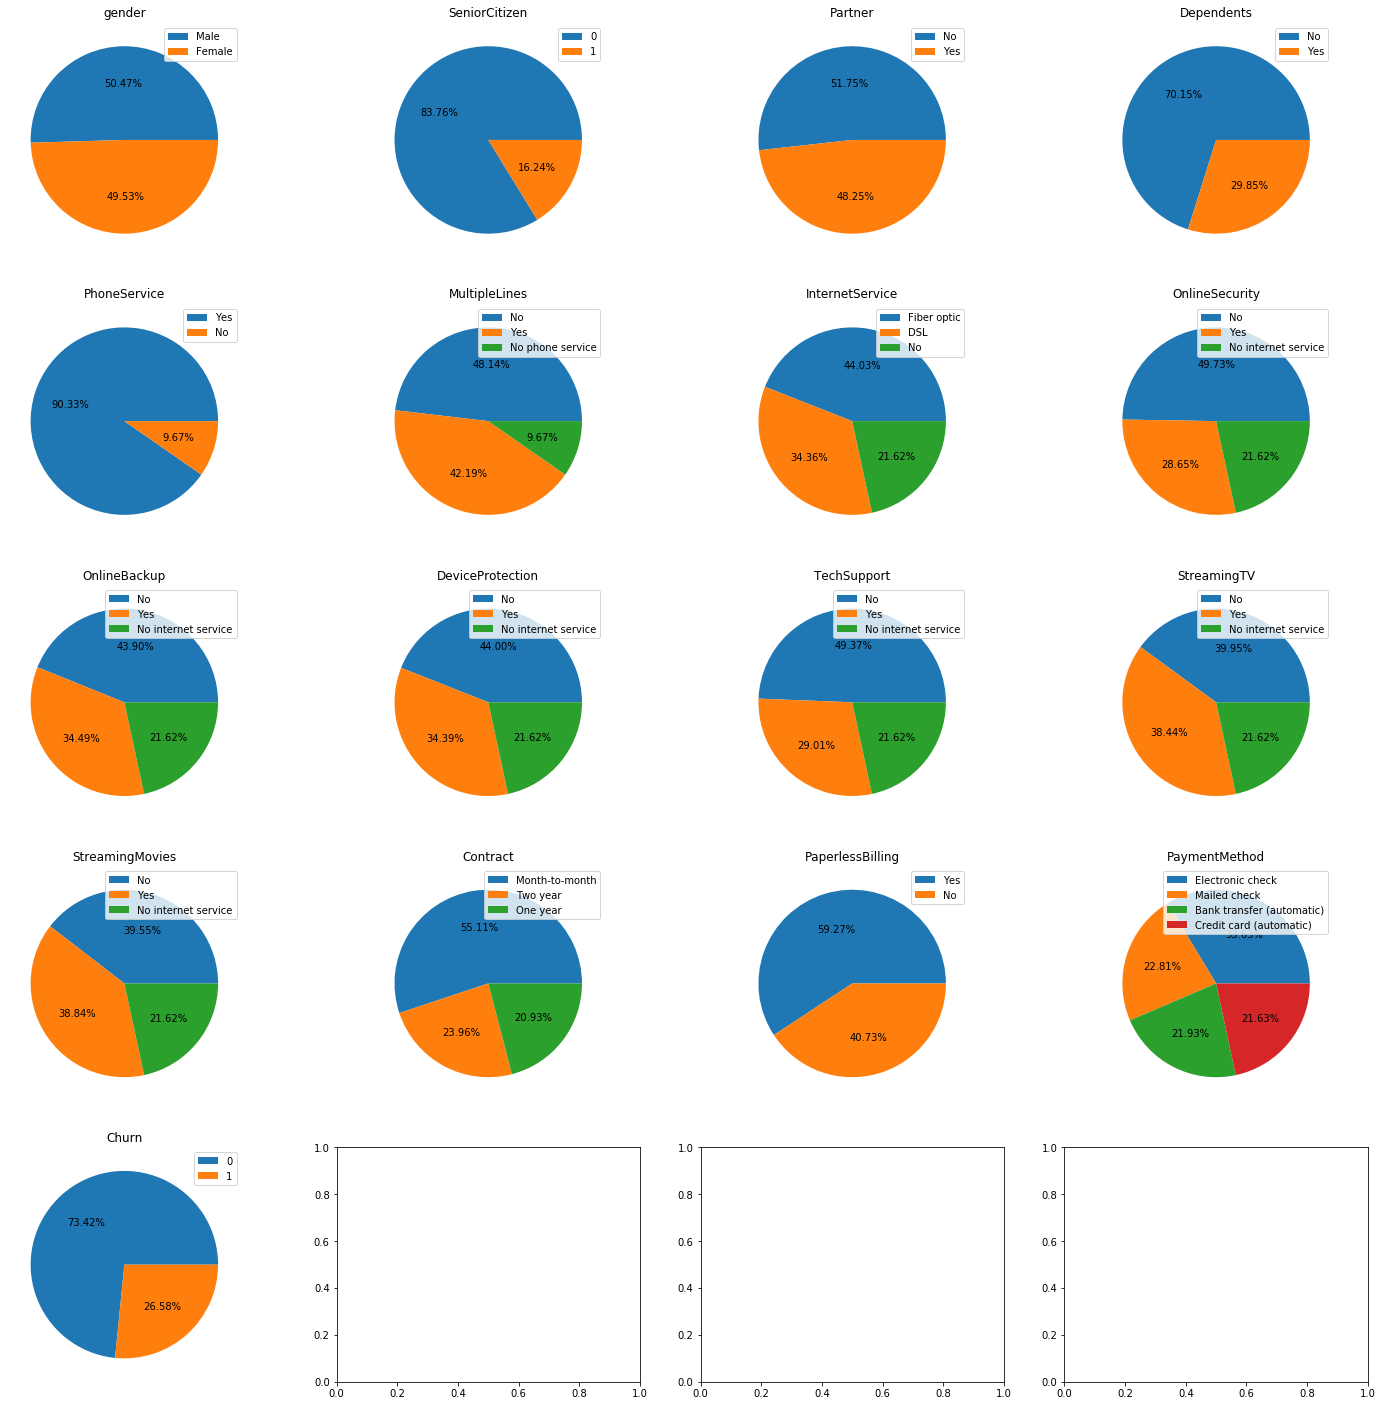

In [7]:
import math

columns = t_data.columns.tolist()
dellist = ['tenure','MonthlyCharges','TotalCharges']
for i in dellist:
    columns.remove(i)
    
f, axes = plt.subplots(math.ceil(len(columns)/4),4, figsize=(25,25))
for col, ax in zip(columns, axes.ravel()):
        data = t_data[col].value_counts().values.tolist()
        labels = t_data[col].value_counts().index.tolist()
        ax.pie(data,autopct='%0.2f%%')
        ax.set_title(col)
        ax.legend(labels,loc='best')

## 2-2. 특성별 이탈율 파악

#### 2-2-1. 카테고리형

In [8]:
import plotly.graph_objects as go
import plotly.offline as pyoff

def cat_plot(col):
    df_plot = t_data.groupby(col).Churn.mean().reset_index()

    plot_data = go.Bar(x = df_plot[col],
                       y = df_plot['Churn'],
                       width = 0.5,
                      marker=dict(color=['green','blue','orange','red']))

    plot_layout = go.Layout(xaxis = {'type':'category'},
                           yaxis = {'title':'Churn Rate'},
                           title = col,
                           plot_bgcolor = 'rgb(243,243,243)',
                           paper_bgcolor = 'rgb(243,243,243)')

    fig = go.Figure(data = plot_data,layout = plot_layout)
    pyoff.iplot(fig)

columns.remove('Churn')
for i in columns:
    cat_plot(i)

#### 2-2-2. 연속형

In [9]:
def num_plot(cols):
    df_plot = t_data.groupby(cols).Churn.mean().reset_index()

    plot_data = go.Scatter(x = df_plot[cols],
                          y = df_plot['Churn'],
                          mode = 'markers',
                          marker = dict(size = 7,
                                        line= dict(width=1), 
                                        color = 'blue',
                                       opacity = 0.8 ))

    plot_layout = go.Layout(xaxis = {'title':cols},
                           yaxis = {'title':'Churn Rate'},
                           title = cols + ' based Churn rate',
                           plot_bgcolor = 'rgb(243,243,243)',
                           paper_bgcolor = 'rgb(243,243,243)')

    fig = go.Figure(data=plot_data, layout=plot_layout)
    pyoff.iplot(fig)

cols = ['tenure','MonthlyCharges','TotalCharges']
for i in cols:
    num_plot(i)

## 2-3. 상관관계 행렬

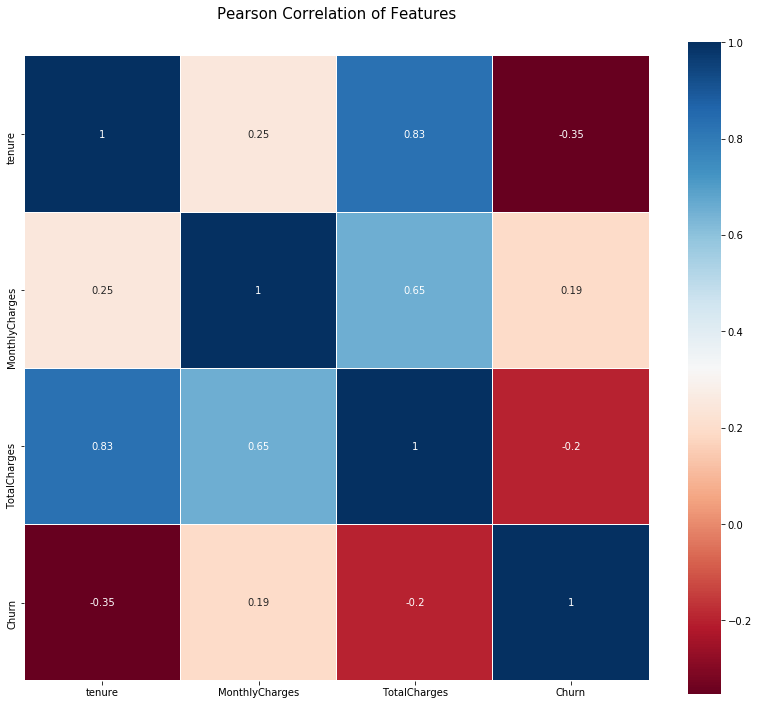

In [10]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(t_data.corr(),linewidths=0.1, vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)

## 2-4. EDA 결과

선택지가 두 개인 특성(13개)
이탈률이 더 높은 label을 df에 기록함
고령자일수록, 청구서를 직접 받을수록, 온라인보안서비스를 신청하지 않았을수록 이탈률이 높음

선택지가 3개 이상(3개)
cat_plot을 통해 확인
Internet Service : 광섬유가 가장 이탈률이 높고 서비스를 신청하지 않은게 가장 이탈률이 낮음
Contract : 계약기간이 짧을수록 이탈률이 높음
PaymentMethod : 직접 계산할수록 이탈률이 높음

연속형 특성(3개)
tenure : 남은기간이 짧을수록 이탈률 높음
MontlyCharges : 이탈률과 선형적 관계없음
TotalCharges : 이탈률과 선형적 관계없음

상관행렬을 통한 인사이트
total charges와montly charges와 tenure 사이에 밀접한 관계가 있음
실제로 확인해본 결과, 식을 발견했음
total charges = montly charges * tenure 

# 3. 특성공학

## 3-1. 데이터 스케일링 - tenure, monthly, total charges - MinMax

#### tenure

(0, 1)

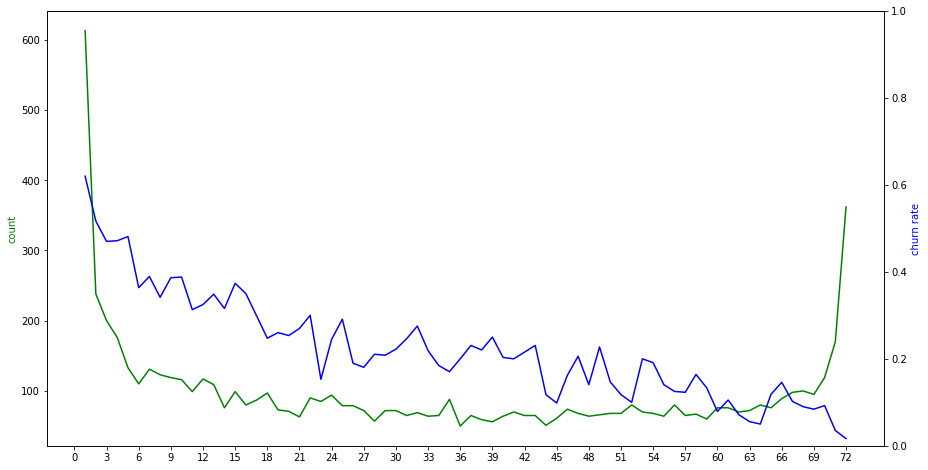

In [11]:
t_tenure = t_data.tenure.value_counts().sort_index()
x = t_tenure.index
y1 = t_tenure.values
y2 = t_data.groupby('tenure').Churn.mean().values

fig, ax1 = plt.subplots(figsize = (15,8))

ax2 = ax1.twinx()

ax1.plot(x,y1,'g-')
ax2.plot(x,y2,'b-')

ax1.set_xticks(range(0,73,3))
ax1.set_ylabel('count', color='g')
ax2.set_ylabel('churn rate', color='b')
ax2.set_ylim((0,1))

In [7]:
tenu = np.array(t_data.tenure).reshape(-1,1)
scaler = MinMaxScaler()
a = scaler.fit_transform(tenu)
t_data['tenure'] = a

#### Monthly Charges

In [8]:
monthly = np.array(t_data.MonthlyCharges).reshape(-1,1)
scaler = MinMaxScaler()
a = scaler.fit_transform(monthly)
t_data['MonthlyCharges'] = a

#### Total Charges

In [9]:
total = np.array(t_data.TotalCharges).reshape(-1,1)
scaler = MinMaxScaler()
a = scaler.fit_transform(total)
t_data['TotalCharges'] = a

## 3-2. 원 핫 인코딩

In [10]:
t_data_dummies = t_data.drop('Churn',axis=1)
t_data_dummies = pd.get_dummies(t_data_dummies)
t_data_dummies['Churn'] = t_data['Churn']

In [16]:
#t_data_dummies.to_csv(r'C:\Users\김상휘\Desktop\Hwi\한이음-kt\data\data_Hwi.csv',index=False)

# 4. 모델링

In [11]:
data = t_data_dummies.drop('Churn',axis=1)
target = t_data_dummies.Churn

seed = 77
X_train_val, X_test, y_train_val, y_test = train_test_split(data,target,random_state = seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val,random_state = seed)

## 4-1. 로지스틱 회귀

#### 4-1-1. 학습 및 예측

In [18]:
model = LogisticRegression().fit(X_train,y_train)
y_pre = model.predict(X_val)

#### 4-1-2. 모델 평가 (Validation set) 지표

##### - 지표 1. 정확도, 정밀도, 재현율, F1 점수

In [14]:
def evaluate(y_real,y_pred):
    print('Accuracy : {:.6f}'.format(accuracy_score(y_real, y_pred))) #정확도 : 예측이 정답과 얼마나 정확한가
    print('Precision : {:.6f}'.format(precision_score(y_real, y_pred))) #정밀도 : 예측한 것 중에서 정답의 비율
    print('Recall : {:.6f}'.format(recall_score(y_real, y_pred))) #재현율 : 정답 중에서 예측한 것의 비율
    print('F1 score : {:.6f}'.format(f1_score(y_real, y_pred))) #정밀도와 재현율의 (조화)평균 - 정밀도와 재현율이 비슷할수록 높은 점수
    print('\nConfusion Matrix : \n {}'.format(confusion_matrix(y_real, y_pred, labels = [1,0]))) # labels를 설정해주지 않으면 순서가 바뀜

In [20]:
evaluate(y_val,y_pre)

Accuracy : 0.793025
Precision : 0.604240
Recall : 0.515060
F1 score : 0.556098

Confusion Matrix : 
 [[171 161]
 [112 875]]


##### 해석 tip

- TP : 양성으로 잘 판단했다
- FN : 음성으로 잘못 판단했다 -> 실제로는 양성이다
- FP : 양성으로 잘못 판단했다 -> 실제로는 음성이다
- TN : 음성으로 잘 판단했다

True / False : 판단 결과

Positive(양성)(1) / Negative(음성)(0) : 나의 추론

- 정밀도 : TP / TP+FP(양성으로 예측한것) : 양성으로 예측한 것 중에 실제 양성인것
- 재현율, 민감도(TPR) : TP / TP+FN(실제 양성인 것) : 실제 양성인 것 중에 양성으로 예측한 것
- 특이도 : TN / FP+TN(실제 음성인 것) : 실제 음성인 것 중에 음성으로 예측한 것
- 1-특이도(FPR) : FP / FP+TN : 실제 음성인 것 중에 양성으로 예측한 것

임계값이 낮다 -> 대부분 양성으로 판단하겠다 -> 재현율(예측양성/실제양성)이 높고, 정밀도(실제양성/예측양성)가 낮다

##### - 지표 2. 정밀도-재현율 곡선

- pr curve에는 TN(실제 음성을 음성으로 판단한 것)이 관여하지 않는다
- 따라서 False(음성)인 것을 판단하는 비중이 적다는 것
- 안그래도 중요성이 적은 False로 치우친 불균형 데이터셋에서 pr curve 사용
- ex. 암 환자 색출 - 음성을 양성으로 판단하는 오류보다, 양성을 음성으로 판단하는 오류에 더 치명적 => 양성 클래스를 집중 탐지해야함

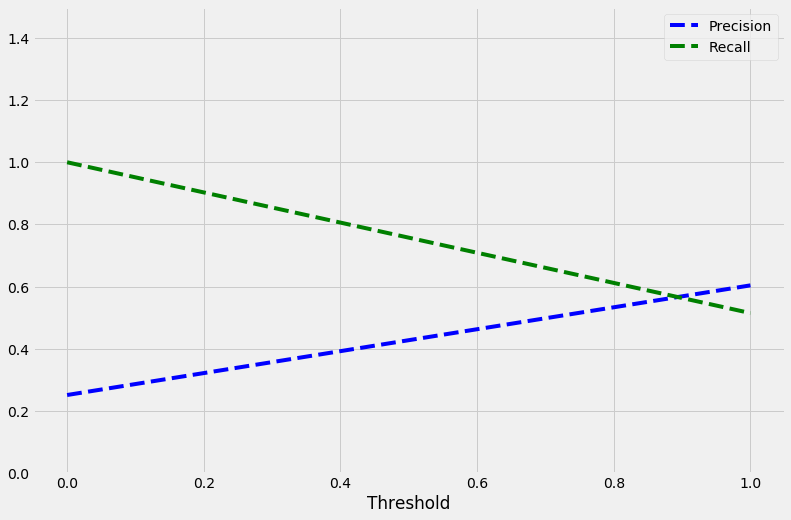

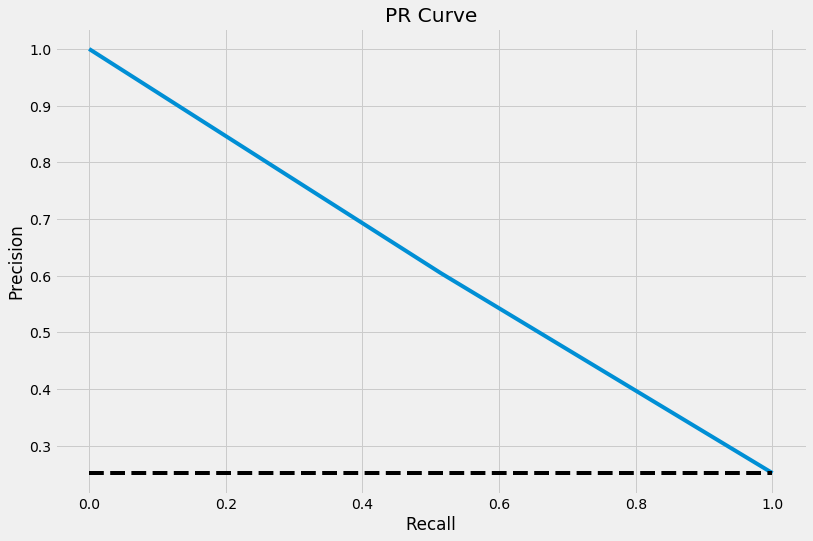

In [21]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pre) #임계값의 값이 하나 부족

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper right")
    plt.ylim(0, 1.5)
    
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12, 8))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(recalls,precisions)
b_line = len(y_val[y_val==1]) / len(y_val)
plt.plot([0, 1], [b_line, b_line], "k--")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve");

In [22]:
pr_auc = auc(recalls, precisions)
print('AUC(PR curve 아래면적) :', pr_auc)

AUC(PR curve 아래면적) : 0.6206813459793465


##### - 지표 3. ROC 곡선

- 양성과 음성의 판단 중요도가 비슷할 경우 사용
- ex. 개와 고양이 분류
- 모든 threshold에 대해 얼마나 잘 예측하는지에 대한 곡선
- 하나의 값으로 비교하기 위해 AUC 개념 도입

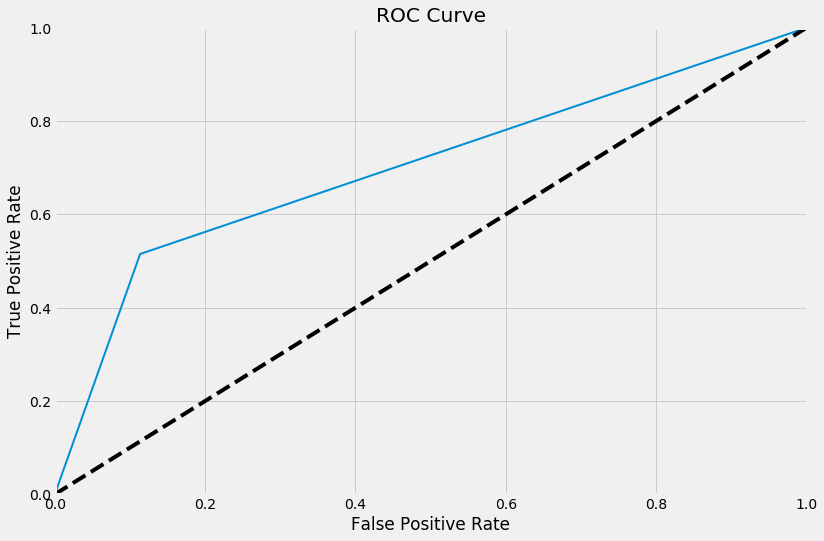

In [23]:
fpr, tpr, thresholds = roc_curve(y_val, y_pre)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    
plt.figure(figsize=(12,8)); 
plot_roc_curve(fpr, tpr)
plt.show();

In [24]:
roc_auc = roc_auc_score(y_val, y_pre)
print('AUC(roc curve 아래면적) :', roc_auc)

AUC(roc curve 아래면적) : 0.7007925318294455


#### 4-1-3. 최적의 매개변수 구하기

In [25]:
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty, C=C, solver=solver)

grid = GridSearchCV(estimator = LogisticRegression(), param_grid=param_grid, scoring='average_precision', verbose=1, n_jobs=-1, cv=5, iid=True)

grid_result = grid.fit(X_train_val, y_train_val)

print('Gridsearch by using AUC')
print('best parameter : {}'.format(grid.best_params_))
print('best AUC score of CV : {:.3f}'.format(grid.best_score_)) # 교차검증의 평균 정확도
print('best AUC score of test set : {:.3f}'.format(grid.score(X_test,y_test))) # 최적의 매개변수와 전체 train 데이터로 만든 모델로 평가한 점수

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 145 out of 160 | elapsed:    8.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    9.7s finished


Gridsearch by using AUC
best parameter : {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
best AUC score of CV : 0.655
best AUC score of test set : 0.659


#### 4-1-4. 테스트

In [26]:
y_pred = grid_result.predict(X_test)

evaluate(y_test, y_pred)

Accuracy : 0.810011
Precision : 0.670025
Recall : 0.567164
F1 score : 0.614319

Confusion Matrix : 
 [[ 266  203]
 [ 131 1158]]


#### 4-1-5. 특성 중요도

In [27]:
importance = model.coef_[0]
df = pd.DataFrame(data=importance,index=X_train.columns,columns=['importance'])
df = df.sort_values(by='importance')

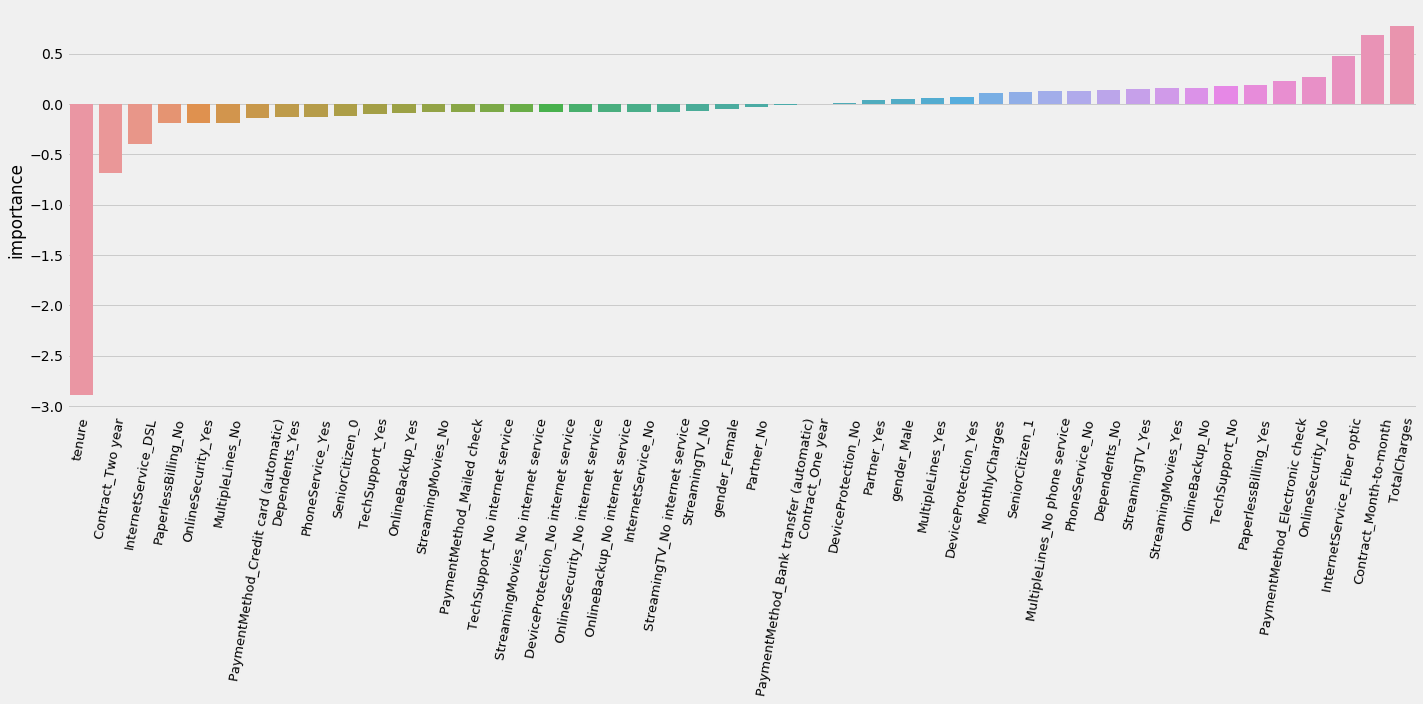

In [28]:
plt.figure(figsize=(20,10))
ax = sns.barplot(df.index,df.importance)
ax.set_xticklabels(df.index,rotation=80,fontsize=13)
plt.tight_layout()
plt.show()

# 앙상블

1. 배깅(Bagging, Bootstrap Aggregating)
 - 병렬
 - 샘플을 다시 샘플링(복원추출)해서 취합함
 - ex) 랜덤포레스트

2. 부스팅(Boosting)
 - 순차적
 - 약한 분류기의 성능을 순차적으로 향상시키고 모두 합쳐 강한 분류기를 생성
 
 2-1. 중요한 데이터(잘못 분류된 데이터)에 대해 weight를 줌(순간적으로 뻥튀기 시킴) - AdaBoost
 
 2-2. 실제값과 예측값의 차이(loss)를 훈련데이터에 투입, gradient를 이용(learning rate로 조절)하여 모델 개선 - XGBoost, lightGBM, CatBoost
 
Tip, XGBoost, CatBoost : level-wise // lightGBM : leaf-wise


## 4-2. XGBOOST

개념

- Extreme Gradient Boosting
- 부스팅(Boosting)의 한 종류, 분류기를 사용할수록 정확도가 높아짐
- Y = w1*M(x) + w2*G(x) + w3*H(x) + error (error를 더 자세히 분류하기 위한 분류기 생성)
- Greedy algorithm 을 통해 분류기들을 찾고, 분산처리를 활용해 가중치를 구함

파라미터
- *booster : 어떤 부스터를 쓸건지 [ 'gbtree'(d),'gblinear','dart' ]
- *learning_rate(eta) : 0.01~0.2 사이값 [0.3(d)]
- *num_iterations : 나무 부스팅을 몇번 할 것인가, 1000이상 권장 [100(d)]
- early_stopping_rounds : 몇 번 동안 validation 셋에 발전이 없어야 그만둘건지
- num_feature : feature 차원의 숫자를 정해야하는 경우, 가능한 많이(d)
- *max_depth : 나무 깊이를 얼만큼 할건지, 3-10 권장 [6(d)]
- num_leaves : 그 트리가 가질 수 있는 잎사귀 수
- bagging_fraction(subsample) : 행 샘플링, 다양성 높인다
- feature_fraction(colsample) : 열 샘플링, 다양성을 높인다, 0.5~0.9 권장 [1(d):샘플링X]
- lambda : L2 규제에 달리는 가중치, 클수록 보수적
- alpha : L1 규제에 달리는 가중치, 클수록 보수적
- objective : 목적함수 ['reg:linear'선형회귀(d),'binary:logistic'이진분류,'count:poisson','multi:softprob'..]
- *eval_metric : 모델의 평가함수 조정 ['rmse','mae','logloss''auc','map'(mean average precision'..]
- min_child_weight : leaf 노드로 인정되는 최소 샘플 수 [1(d)]

특징

- plot_importance를 통해 feature importance 확인가능

#### 4-2-1. 학습 및 예측

In [12]:
xgb_model = xgb.XGBClassifier(booster = 'gbtree',
                         objective = 'binary:logistic',
                         eval_metric = 'error',
                         seed= seed)
model = xgb_model.fit(X_train, y_train)
y_pre = model.predict(X_val)

#### 4-2-2. 모델 평가 (Validation set) 지표

##### - 지표 1. 정확도, 정밀도, 재현율, F1 점수

In [15]:
evaluate(y_val,y_pre)

Accuracy : 0.780895
Precision : 0.572391
Recall : 0.512048
F1 score : 0.540541

Confusion Matrix : 
 [[170 162]
 [127 860]]


#### 4-2-3. 최적의 매개변수 구하기

In [17]:
param_grid = {'booster': ['gbtree'],
                  'objective' : ['binary:logistic'], 
                  'eval_metric' : ['error'],
                  'n_estimators':[100],
                  'max_depth': [3,5,7,9],
                  'min_child_weight':[1,3,5,7],
                  'learning_rate' : [0.01,0.05,0.1],
                  'scale_pos_weight':[1,3,5],
                  'colsample_bytree':[0.5,0.7,0.9]}

grid = GridSearchCV(estimator = xgb.XGBClassifier(), param_grid=param_grid, scoring='average_precision', verbose=1, n_jobs=-1, cv=5,)

grid_result = grid.fit(X_train_val, y_train_val)

print('best parameter : {}'.format(grid.best_params_))
print('best score of CV : {:.3f}'.format(grid.best_score_)) # 교차검증의 평균 정확도
print('best score of test set : {:.3f}'.format(grid.score(X_test,y_test))) # 최적의 매개변수와 전체 train 데이터로 만든 모델로 평가한 점수

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 15.6min finished


best parameter : {'booster': 'gbtree', 'colsample_bytree': 0.5, 'eval_metric': 'error', 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'objective': 'binary:logistic', 'scale_pos_weight': 1}
best score of CV : 0.664
best score of test set : 0.677


#### 4-2-4. 테스트

In [18]:
y_pred = grid_result.predict(X_test)

evaluate(y_test, y_pred)

Accuracy : 0.807736
Precision : 0.681440
Recall : 0.524520
F1 score : 0.592771

Confusion Matrix : 
 [[ 246  223]
 [ 115 1174]]


#### 4-2-5. 특성중요도

- weight(d) : 모든 트리에서 각 feature가 데이터를 분할하는데 사용된 횟수
- cover : weight개념에서 훈련데이터 개수에 따라 가중치를 적용받은 것
- gain : 분할에 각 변수를 사용할때마다 감소한 평균 훈련 손실

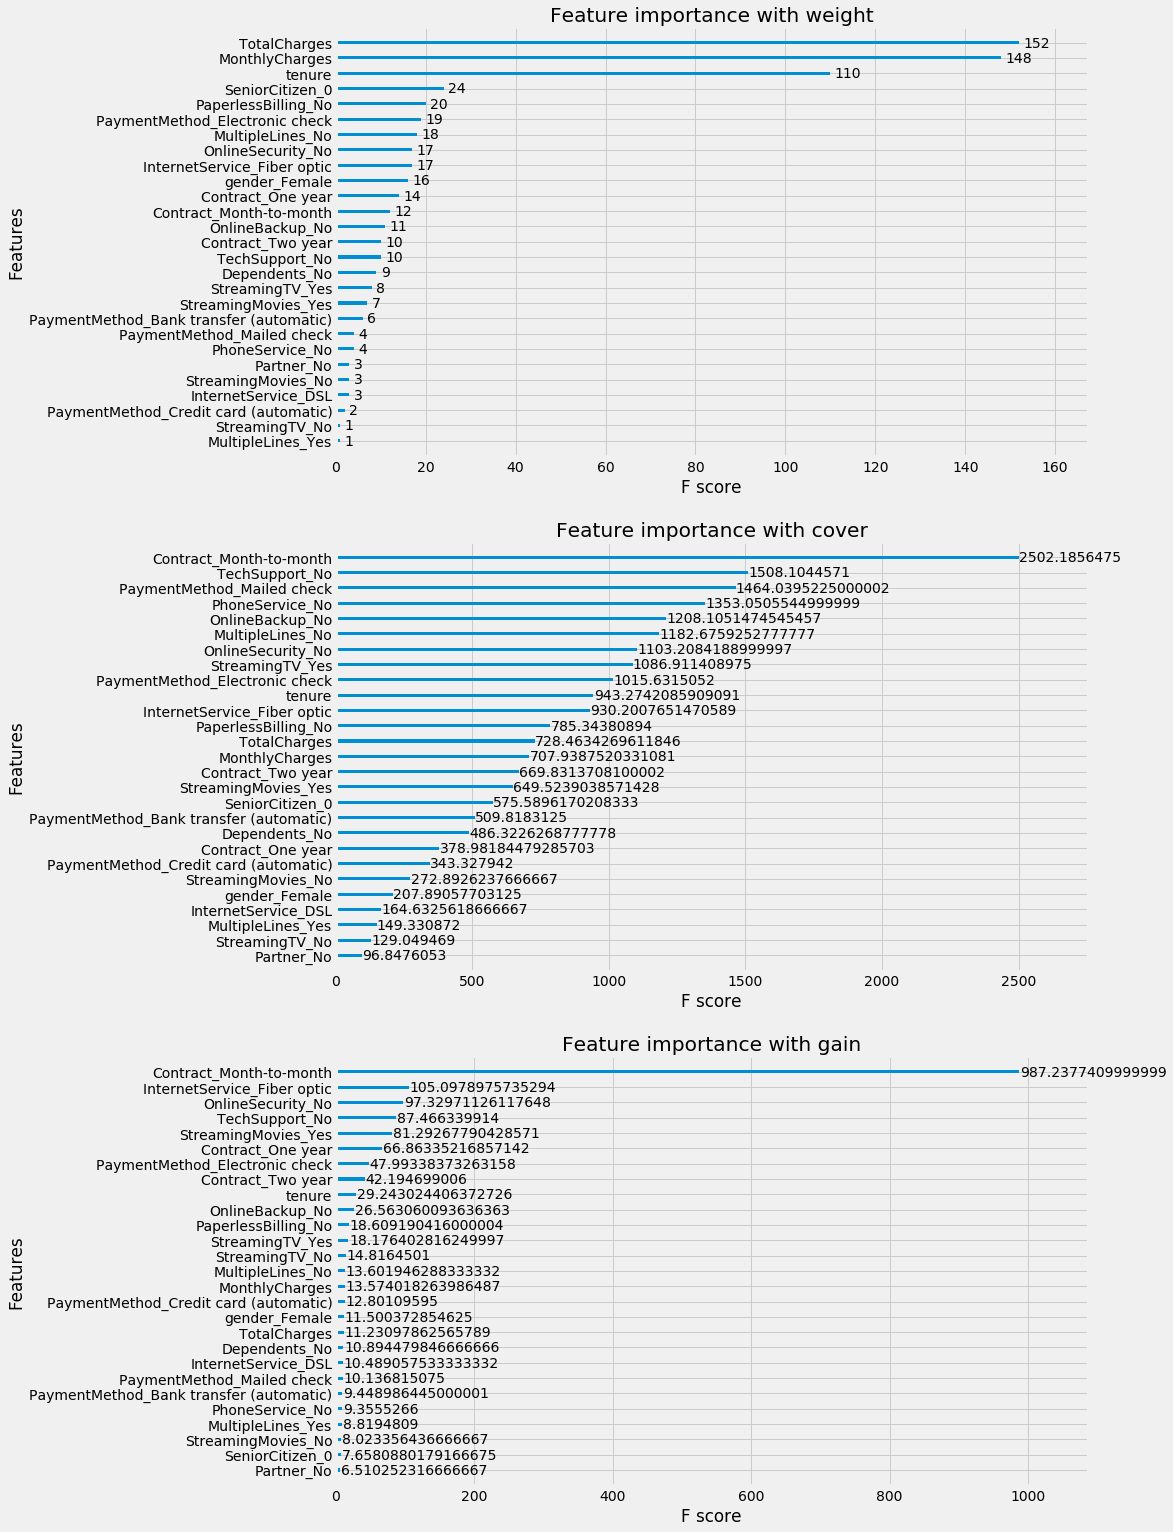

In [33]:
fig, ax = plt.subplots(3,1,figsize = (12,25))
for i, type_ in enumerate(['weight','cover','gain']):
    xgb.plot_importance(grid_result.best_estimator_,importance_type = type_, ax=ax[i])
    ax[i].set_title('Feature importance with '+type_)

## 4-3. LightGBM

- 대용량 셋에 유용함

< ROW >

Goss(Gradient Based One Side Sampling)

 : 데이터 개수를 줄일 때 큰 gradient(잔차)를 가진 데이터는 놔두고, 작은 gradient를 가진 데이터는 랜덤하게 드랍함(One side sampling의 개념)
 
 - 순서
  1. 모델을 예측함
  2. 실제값과 예측값과의 loss를 구함
  3. loss 순서대로 정렬한 후, 상위 N개는 그대로 저장(ex. 100개 중 30개면 a=0.3)
  4. 나머지 70개 중 10개만 랜덤 샘플링(b=0.1)
  5. 즉, 고 그라디언트 30개와 스몰 그라디언트 10개로 다시 샘플링 된 것
  6. 줄어든 스몰 그라디언트에 대해 weight(1-a/b)를 부여함
  7. 전체 데이터 셋에 대해 loss와 weight를 고려한 약한 예측기를 만들어 전체 데이터 셋에 추가함

< COLUMNS >

EFB(Exclusive Feature Bundling)

 : 비슷한(상호배타적이지 않은) feature들끼리는 통합하여 계산량을 줄임

#### 4-3-1. 학습 및 예측

In [34]:
lgb_model = lgb.LGBMClassifier(booster = 'gbtree',
                         objective = 'binary',
                         seed= seed)
model = lgb_model.fit(X_train, y_train)
y_pre = model.predict(X_val)

#### 4-3-2. 모델 평가 (Validation set) 지표

##### - 지표 1. 정확도, 정밀도, 재현율, F1 점수

In [35]:
evaluate(y_val,y_pre)

Accuracy : 0.793783
Precision : 0.605634
Recall : 0.518072
F1 score : 0.558442

Confusion Matrix : 
 [[172 160]
 [112 875]]


#### 4-3-3. 최적의 매개변수 구하기

In [36]:
param_grid = {'booster': ['gbtree'],
             'objective' : ['binary'],
             'learning_rate':[0.01,0.05,0.1],
              'num_leaves' : [12,15,18],
              'feature_fraction' : [0.5,0.7,0.9],
              'subsample' : [0.5,0.7,0.9],
              'min_child_weight':[1,3,5,7]
             }

grid = GridSearchCV(estimator = lgb.LGBMClassifier(), param_grid=param_grid, scoring='average_precision', verbose=1, n_jobs=-1, cv=5,)

grid_result = grid.fit(X_train_val, y_train_val)

print('best parameter : {}'.format(grid.best_params_))
print('best score of CV : {:.3f}'.format(grid.best_score_)) # 교차검증의 평균 정확도
print('best score of test set : {:.3f}'.format(grid.score(X_test,y_test))) # 최적의 매개변수와 전체 train 데이터로 만든 모델로 평가한 점수

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   52.4s


best parameter : {'booster': 'gbtree', 'feature_fraction': 0.5, 'learning_rate': 0.05, 'min_child_weight': 7, 'num_leaves': 12, 'objective': 'binary', 'subsample': 0.5}
best score of CV : 0.660
best score of test set : 0.677


[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  1.2min finished


#### 4-3-4. 테스트

In [37]:
y_pred = grid_result.predict(X_test)

evaluate(y_test, y_pred)

Accuracy : 0.803754
Precision : 0.667568
Recall : 0.526652
F1 score : 0.588796

Confusion Matrix : 
 [[ 247  222]
 [ 123 1166]]


#### 4-3-5. 특성중요도

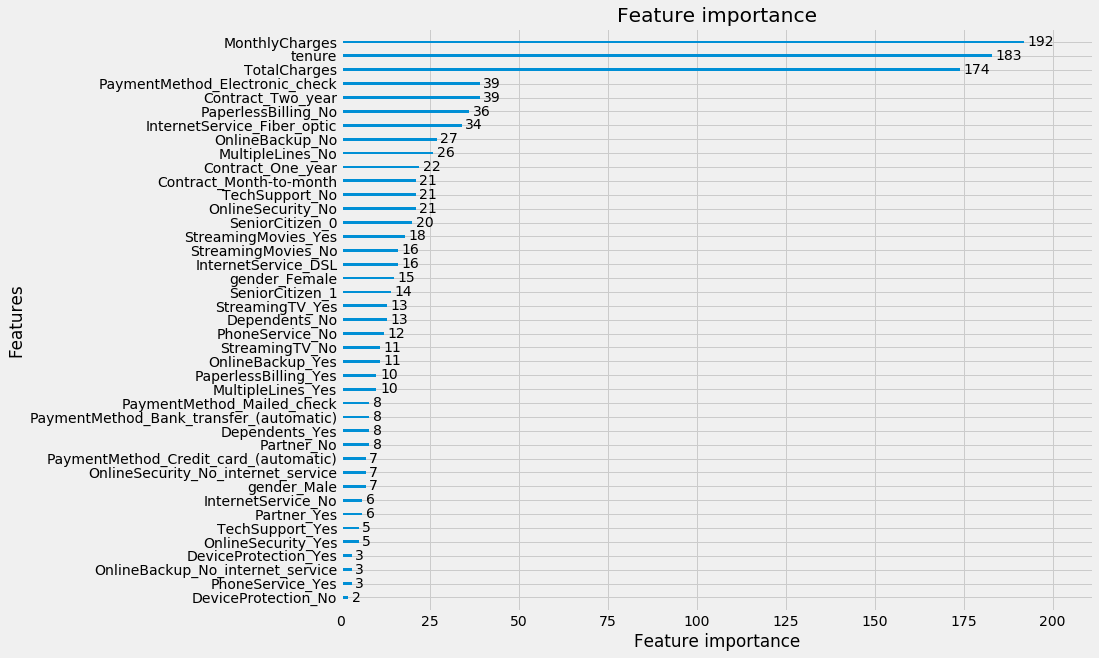

In [38]:
fig, ax = plt.subplots(1,1,figsize = (12,10))
lgb.plot_importance(grid_result.best_estimator_, ax=ax)

## 4-4. CatBoost

개념 및 특징
- 대부분 카테고리형 범주인 데이터셋에 사용
- Level wise tree
- Ordered Boost : 데이터의 일부만 가지고 잔차를 계산 후, 모델 생성.나머지 데이터의 잔차는 해당 모델로 계산.
- Random Permutation(무작위 순열) : 순서를 매번 섞어줌
- Ordered Target Encoding(=Target Encoding, Mean Encoding, Response Encoding) : 카테고리 특징의 데이터들을 해당 레이블의 예측값 평균으로 대체/ 모델학습에 사용된 target데이터만 사용. 즉, 같은 레이블이더라도 매번 대체되는 평균값이 변화됨 -> data leakage 방지
- Categorical Feature Combinations : 레이블을 예측하는데에 있어 불필요한 특성 줄여줌.
- One Hot Encoding : 자체적으로 원핫인코딩 시행, one_hot_max_size 파라미터로 기준이 되는 데이터 크기 지정
- Optimized Parameter Tuning : 굳이 튜닝하지 않아도 성능이 좋음. 하더라도 learning_rate, random_strength, L2_regulariser 이 정도 적당



#### 4-4-1. 학습 및 예측

In [39]:
cat_features = list(X_train.columns[3:])

In [40]:
cb_model = cb.CatBoostClassifier()
model = cb_model.fit(X_train, y_train,cat_features = cat_features)
y_pre = model.predict(X_val)

Learning rate set to 0.018532
0:	learn: 0.6800431	total: 61.2ms	remaining: 1m 1s
1:	learn: 0.6685506	total: 66.1ms	remaining: 33s
2:	learn: 0.6569669	total: 70.8ms	remaining: 23.5s
3:	learn: 0.6459188	total: 77.4ms	remaining: 19.3s
4:	learn: 0.6351574	total: 82.8ms	remaining: 16.5s
5:	learn: 0.6254241	total: 87.4ms	remaining: 14.5s
6:	learn: 0.6169110	total: 92.4ms	remaining: 13.1s
7:	learn: 0.6073044	total: 97ms	remaining: 12s
8:	learn: 0.5986892	total: 102ms	remaining: 11.2s
9:	learn: 0.5901767	total: 107ms	remaining: 10.6s
10:	learn: 0.5827722	total: 112ms	remaining: 10.1s
11:	learn: 0.5756545	total: 117ms	remaining: 9.64s
12:	learn: 0.5682936	total: 122ms	remaining: 9.24s
13:	learn: 0.5618820	total: 128ms	remaining: 9.02s
14:	learn: 0.5554582	total: 135ms	remaining: 8.84s
15:	learn: 0.5494438	total: 141ms	remaining: 8.68s
16:	learn: 0.5432848	total: 148ms	remaining: 8.53s
17:	learn: 0.5379101	total: 152ms	remaining: 8.29s
18:	learn: 0.5330394	total: 158ms	remaining: 8.14s
19:	learn

171:	learn: 0.3831452	total: 1.05s	remaining: 5.06s
172:	learn: 0.3828962	total: 1.06s	remaining: 5.05s
173:	learn: 0.3826829	total: 1.06s	remaining: 5.04s
174:	learn: 0.3824831	total: 1.07s	remaining: 5.04s
175:	learn: 0.3823268	total: 1.07s	remaining: 5.03s
176:	learn: 0.3820549	total: 1.08s	remaining: 5.02s
177:	learn: 0.3818781	total: 1.08s	remaining: 5.01s
178:	learn: 0.3817061	total: 1.09s	remaining: 5s
179:	learn: 0.3815281	total: 1.1s	remaining: 4.99s
180:	learn: 0.3813729	total: 1.1s	remaining: 4.98s
181:	learn: 0.3811428	total: 1.11s	remaining: 4.98s
182:	learn: 0.3808505	total: 1.11s	remaining: 4.97s
183:	learn: 0.3806446	total: 1.12s	remaining: 4.96s
184:	learn: 0.3804527	total: 1.12s	remaining: 4.95s
185:	learn: 0.3803358	total: 1.13s	remaining: 4.95s
186:	learn: 0.3802735	total: 1.14s	remaining: 4.94s
187:	learn: 0.3801360	total: 1.14s	remaining: 4.93s
188:	learn: 0.3798157	total: 1.15s	remaining: 4.92s
189:	learn: 0.3797216	total: 1.16s	remaining: 4.95s
190:	learn: 0.379

333:	learn: 0.3557875	total: 2.1s	remaining: 4.19s
334:	learn: 0.3557503	total: 2.11s	remaining: 4.18s
335:	learn: 0.3555956	total: 2.11s	remaining: 4.18s
336:	learn: 0.3554545	total: 2.12s	remaining: 4.17s
337:	learn: 0.3552456	total: 2.12s	remaining: 4.16s
338:	learn: 0.3551512	total: 2.13s	remaining: 4.15s
339:	learn: 0.3549971	total: 2.14s	remaining: 4.15s
340:	learn: 0.3548821	total: 2.14s	remaining: 4.14s
341:	learn: 0.3547973	total: 2.15s	remaining: 4.13s
342:	learn: 0.3546698	total: 2.15s	remaining: 4.12s
343:	learn: 0.3545108	total: 2.16s	remaining: 4.12s
344:	learn: 0.3544395	total: 2.16s	remaining: 4.11s
345:	learn: 0.3543318	total: 2.17s	remaining: 4.1s
346:	learn: 0.3541225	total: 2.17s	remaining: 4.09s
347:	learn: 0.3540487	total: 2.18s	remaining: 4.08s
348:	learn: 0.3538369	total: 2.19s	remaining: 4.08s
349:	learn: 0.3537525	total: 2.2s	remaining: 4.08s
350:	learn: 0.3534614	total: 2.2s	remaining: 4.07s
351:	learn: 0.3533851	total: 2.21s	remaining: 4.06s
352:	learn: 0.35

503:	learn: 0.3331099	total: 3.13s	remaining: 3.08s
504:	learn: 0.3329975	total: 3.14s	remaining: 3.08s
505:	learn: 0.3328460	total: 3.15s	remaining: 3.07s
506:	learn: 0.3327152	total: 3.15s	remaining: 3.06s
507:	learn: 0.3324938	total: 3.16s	remaining: 3.06s
508:	learn: 0.3323553	total: 3.17s	remaining: 3.05s
509:	learn: 0.3322468	total: 3.17s	remaining: 3.04s
510:	learn: 0.3321677	total: 3.18s	remaining: 3.04s
511:	learn: 0.3320228	total: 3.18s	remaining: 3.03s
512:	learn: 0.3319131	total: 3.19s	remaining: 3.03s
513:	learn: 0.3317616	total: 3.2s	remaining: 3.02s
514:	learn: 0.3315795	total: 3.2s	remaining: 3.02s
515:	learn: 0.3314790	total: 3.21s	remaining: 3.01s
516:	learn: 0.3313537	total: 3.21s	remaining: 3s
517:	learn: 0.3312472	total: 3.22s	remaining: 3s
518:	learn: 0.3309978	total: 3.23s	remaining: 2.99s
519:	learn: 0.3308250	total: 3.23s	remaining: 2.98s
520:	learn: 0.3306966	total: 3.24s	remaining: 2.98s
521:	learn: 0.3305623	total: 3.25s	remaining: 2.97s
522:	learn: 0.330472

670:	learn: 0.3141362	total: 4.18s	remaining: 2.05s
671:	learn: 0.3140360	total: 4.19s	remaining: 2.04s
672:	learn: 0.3139355	total: 4.19s	remaining: 2.04s
673:	learn: 0.3138080	total: 4.2s	remaining: 2.03s
674:	learn: 0.3137324	total: 4.21s	remaining: 2.02s
675:	learn: 0.3136700	total: 4.21s	remaining: 2.02s
676:	learn: 0.3135457	total: 4.22s	remaining: 2.01s
677:	learn: 0.3134956	total: 4.23s	remaining: 2.01s
678:	learn: 0.3133989	total: 4.24s	remaining: 2s
679:	learn: 0.3132461	total: 4.24s	remaining: 2s
680:	learn: 0.3131276	total: 4.25s	remaining: 1.99s
681:	learn: 0.3130131	total: 4.25s	remaining: 1.98s
682:	learn: 0.3129334	total: 4.26s	remaining: 1.98s
683:	learn: 0.3127869	total: 4.27s	remaining: 1.97s
684:	learn: 0.3126910	total: 4.27s	remaining: 1.96s
685:	learn: 0.3126305	total: 4.28s	remaining: 1.96s
686:	learn: 0.3125724	total: 4.28s	remaining: 1.95s
687:	learn: 0.3124869	total: 4.29s	remaining: 1.95s
688:	learn: 0.3124368	total: 4.29s	remaining: 1.94s
689:	learn: 0.31237

844:	learn: 0.2957726	total: 5.23s	remaining: 959ms
845:	learn: 0.2956541	total: 5.23s	remaining: 953ms
846:	learn: 0.2956221	total: 5.24s	remaining: 946ms
847:	learn: 0.2954913	total: 5.24s	remaining: 940ms
848:	learn: 0.2954493	total: 5.25s	remaining: 934ms
849:	learn: 0.2953456	total: 5.26s	remaining: 928ms
850:	learn: 0.2952078	total: 5.26s	remaining: 921ms
851:	learn: 0.2951076	total: 5.27s	remaining: 915ms
852:	learn: 0.2950147	total: 5.27s	remaining: 909ms
853:	learn: 0.2949623	total: 5.28s	remaining: 903ms
854:	learn: 0.2948424	total: 5.29s	remaining: 897ms
855:	learn: 0.2948128	total: 5.29s	remaining: 890ms
856:	learn: 0.2946769	total: 5.3s	remaining: 884ms
857:	learn: 0.2946160	total: 5.3s	remaining: 878ms
858:	learn: 0.2945587	total: 5.31s	remaining: 872ms
859:	learn: 0.2945013	total: 5.32s	remaining: 866ms
860:	learn: 0.2944287	total: 5.32s	remaining: 859ms
861:	learn: 0.2943063	total: 5.33s	remaining: 853ms
862:	learn: 0.2942008	total: 5.34s	remaining: 847ms
863:	learn: 0.

#### 4-4-2. 모델 평가 (Validation set) 지표

##### - 지표 1. 정확도, 정밀도, 재현율, F1 점수

In [41]:
evaluate(y_val,y_pre)

Accuracy : 0.796816
Precision : 0.617647
Recall : 0.506024
F1 score : 0.556291

Confusion Matrix : 
 [[168 164]
 [104 883]]


#### 4-4-3. 최적의 매개변수 구하기

In [42]:
param_grid = {'depth': [4, 7, 10],
              'iterations' : [5, 10], 
              'learning_rate' : [0.03, 0.1, 0.15],
              'l2_leaf_reg': [1,4,9],
              'iterations': [300]
             }

grid = GridSearchCV(estimator = cb.CatBoostClassifier(), param_grid=param_grid, scoring='average_precision', verbose=1, n_jobs=-1, cv=5,)

grid_result = grid.fit(X_train_val, y_train_val,cat_features = cat_features)

print('best parameter : {}'.format(grid.best_params_))
print('best score of CV : {:.3f}'.format(grid.best_score_)) # 교차검증의 평균 정확도
print('best score of test set : {:.3f}'.format(grid.score(X_test,y_test))) # 최적의 매개변수와 전체 train 데이터로 만든 모델로 평가한 점수

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 12.0min finished


0:	learn: 0.6741515	total: 4.26ms	remaining: 1.27s
1:	learn: 0.6566023	total: 7.98ms	remaining: 1.19s
2:	learn: 0.6390679	total: 11.7ms	remaining: 1.16s
3:	learn: 0.6233569	total: 15.8ms	remaining: 1.17s
4:	learn: 0.6095747	total: 20ms	remaining: 1.18s
5:	learn: 0.5964142	total: 23.8ms	remaining: 1.17s
6:	learn: 0.5835526	total: 27.1ms	remaining: 1.14s
7:	learn: 0.5722545	total: 32.1ms	remaining: 1.17s
8:	learn: 0.5611686	total: 36.5ms	remaining: 1.18s
9:	learn: 0.5524730	total: 40.2ms	remaining: 1.17s
10:	learn: 0.5434831	total: 44.5ms	remaining: 1.17s
11:	learn: 0.5353588	total: 48.8ms	remaining: 1.17s
12:	learn: 0.5283093	total: 52.8ms	remaining: 1.16s
13:	learn: 0.5209330	total: 56.5ms	remaining: 1.15s
14:	learn: 0.5147859	total: 60.7ms	remaining: 1.15s
15:	learn: 0.5087430	total: 65.2ms	remaining: 1.16s
16:	learn: 0.5037960	total: 68.8ms	remaining: 1.15s
17:	learn: 0.4991836	total: 72.8ms	remaining: 1.14s
18:	learn: 0.4951040	total: 77.7ms	remaining: 1.15s
19:	learn: 0.4909303	tot

170:	learn: 0.3972587	total: 686ms	remaining: 517ms
171:	learn: 0.3970533	total: 689ms	remaining: 513ms
172:	learn: 0.3969420	total: 693ms	remaining: 509ms
173:	learn: 0.3968072	total: 696ms	remaining: 504ms
174:	learn: 0.3967558	total: 700ms	remaining: 500ms
175:	learn: 0.3965409	total: 703ms	remaining: 496ms
176:	learn: 0.3964051	total: 707ms	remaining: 491ms
177:	learn: 0.3963099	total: 711ms	remaining: 487ms
178:	learn: 0.3961986	total: 715ms	remaining: 483ms
179:	learn: 0.3961130	total: 718ms	remaining: 479ms
180:	learn: 0.3960337	total: 721ms	remaining: 474ms
181:	learn: 0.3959840	total: 724ms	remaining: 470ms
182:	learn: 0.3958336	total: 728ms	remaining: 465ms
183:	learn: 0.3957557	total: 732ms	remaining: 461ms
184:	learn: 0.3956322	total: 735ms	remaining: 457ms
185:	learn: 0.3955394	total: 739ms	remaining: 453ms
186:	learn: 0.3954597	total: 743ms	remaining: 449ms
187:	learn: 0.3953422	total: 746ms	remaining: 444ms
188:	learn: 0.3952006	total: 750ms	remaining: 440ms
189:	learn: 

#### 4-4-4. 테스트

In [43]:
y_pred = grid_result.predict(X_test)

evaluate(y_test, y_pred)

Accuracy : 0.810011
Precision : 0.680965
Recall : 0.541578
F1 score : 0.603325

Confusion Matrix : 
 [[ 254  215]
 [ 119 1170]]
